<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S10-V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [0]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   all.py	       execute.py    __pycache__
AlbTrainTransforms.py  DataLoaders.py  Gradcam.py    resNet.py
albumentations.py      displayData.py  LR_Finder.py  rohan_library.py


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [0]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf

**Albumentations**

In [0]:
# from albumentations import Compose, Normalize
# from albumentations.pytorch import ToTensor
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [0]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders()
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [0]:
dataiter = iter(trainLoader)
# iter(trainLoader).next()

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


**Displaying Random Images**

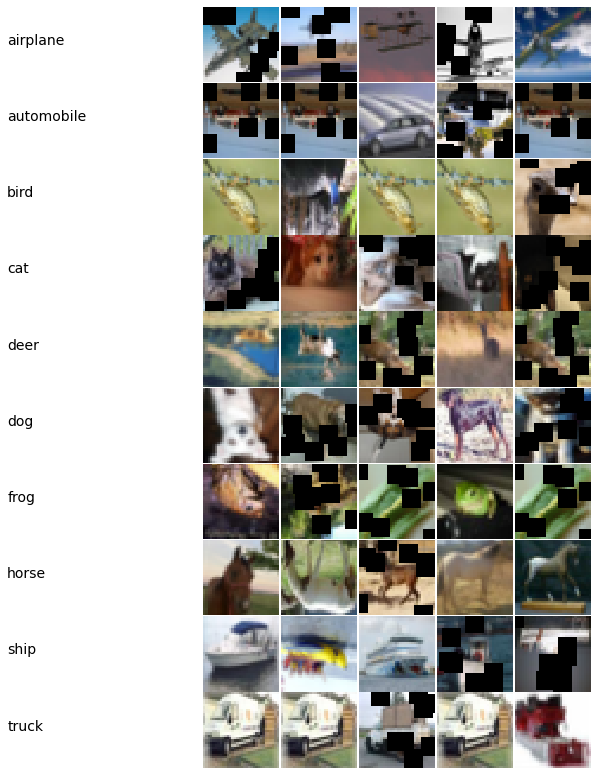

In [0]:
display.classImages(trainLoader)

**Model Summary**

In [0]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

**LR Finder**

In [0]:
torch.manual_seed(10)
criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-5, weight_decay=1e-4)
model = ResNet18().to(device)


**FastAI Approach**

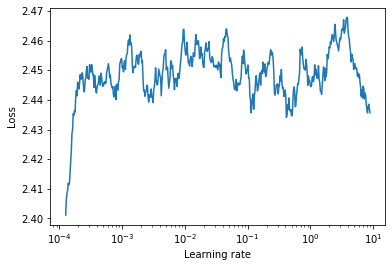

In [0]:
def fastaiApproach(model, optimizer, criterion, device ='cuda'): # fastai approach
  lrF = lrf.LRFinder(model, optimizer, criterion, device)
  lrF.range_test(trainLoader, end_lr=10, num_iter =500, step_mode='exp')
  lrF.plot()
  lrF.reset()

def lsApproach(model, optimizer, criterion, device ='cuda'): # leslie smith approach
  lrF = lrf.LRFinder(model, optimizer, criterion, device)
  lrF.range_test(trainLoader, testLoader, end_lr=10, num_iter =100, step_mode='exp')
  lrF.plot()
  lrF.reset()


fastaiApproach(model, optimizer, criterion, device)


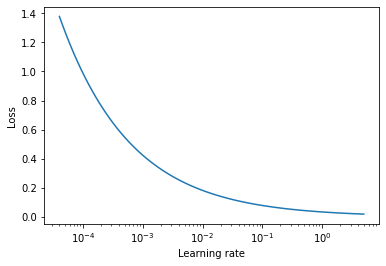

In [0]:
lsApproach(model, optimizer, criterion, device)

**Modelling**

In [0]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = ResNet18().to(device)


criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum=0.9, weight_decay=1e-4, nesterov = True) # change it to 0.01 or 0.009
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience=2, verbose=False)


model1 = execute.Test_Train(model, device, optimizer, criterion)
EPOCHS = 15
# print(criterion1)

for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  1


Loss=3.051821708679199 Batch_id=390 Accuracy=20.06: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 2.0006).  Saving model ...

Test set: Average loss: 2.0006, Accuracy: 2940/10000 (29.40%)

EPOCH:  2


Loss=2.9263100624084473 Batch_id=390 Accuracy=29.64: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (2.0006 --> 1.8202).  Saving model ...

Test set: Average loss: 1.8202, Accuracy: 3606/10000 (36.06%)

EPOCH:  3


Loss=2.7586541175842285 Batch_id=390 Accuracy=34.10: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.8202 --> 1.7866).  Saving model ...

Test set: Average loss: 1.7866, Accuracy: 3959/10000 (39.59%)

EPOCH:  4


Loss=2.679669141769409 Batch_id=390 Accuracy=37.26: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.7866 --> 1.5919).  Saving model ...

Test set: Average loss: 1.5919, Accuracy: 4149/10000 (41.49%)

EPOCH:  5


Loss=2.855916976928711 Batch_id=390 Accuracy=39.51: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.7221, Accuracy: 4438/10000 (44.38%)

EPOCH:  6


Loss=2.8252975940704346 Batch_id=390 Accuracy=41.44: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.5919 --> 1.5745).  Saving model ...

Test set: Average loss: 1.5745, Accuracy: 4598/10000 (45.98%)

EPOCH:  7


Loss=2.6664507389068604 Batch_id=390 Accuracy=43.26: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.5745 --> 1.3471).  Saving model ...

Test set: Average loss: 1.3471, Accuracy: 4777/10000 (47.77%)

EPOCH:  8


Loss=2.4329025745391846 Batch_id=390 Accuracy=45.08: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.3471 --> 1.0496).  Saving model ...

Test set: Average loss: 1.0496, Accuracy: 4843/10000 (48.43%)

EPOCH:  9


Loss=2.5154361724853516 Batch_id=390 Accuracy=46.75: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.5204, Accuracy: 5010/10000 (50.10%)

EPOCH:  10


Loss=2.5237269401550293 Batch_id=390 Accuracy=47.92: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.0496 --> 0.7193).  Saving model ...

Test set: Average loss: 0.7193, Accuracy: 5260/10000 (52.60%)

EPOCH:  11


Loss=2.365727424621582 Batch_id=390 Accuracy=49.12: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3913, Accuracy: 5346/10000 (53.46%)

EPOCH:  12


Loss=2.4357638359069824 Batch_id=390 Accuracy=50.33: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0906, Accuracy: 5522/10000 (55.22%)

EPOCH:  13


Loss=2.310150146484375 Batch_id=390 Accuracy=51.09: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1671, Accuracy: 5616/10000 (56.16%)

EPOCH:  14


Loss=2.3765974044799805 Batch_id=390 Accuracy=52.77: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0467, Accuracy: 5709/10000 (57.09%)

EPOCH:  15


Loss=2.757110834121704 Batch_id=390 Accuracy=52.99: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]



Test set: Average loss: 1.2416, Accuracy: 5712/10000 (57.12%)



**Learning Rate = 1e-3**

In [0]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = ResNet18().to(device)


criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum=0.9, weight_decay=1e-4, nesterov = True) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience=2, verbose=False)


model1 = execute.Test_Train(model, device, optimizer, criterion)
EPOCHS = 15
# print(criterion1)

for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  1


Loss=2.510089874267578 Batch_id=390 Accuracy=33.66: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.7621).  Saving model ...

Test set: Average loss: 1.7621, Accuracy: 4329/10000 (43.29%)

EPOCH:  2


Loss=2.4822304248809814 Batch_id=390 Accuracy=46.62: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.7621 --> 1.6242).  Saving model ...

Test set: Average loss: 1.6242, Accuracy: 5120/10000 (51.20%)

EPOCH:  3


Loss=2.5325515270233154 Batch_id=390 Accuracy=52.44: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.6242 --> 1.0332).  Saving model ...

Test set: Average loss: 1.0332, Accuracy: 5595/10000 (55.95%)

EPOCH:  4


Loss=2.1737377643585205 Batch_id=390 Accuracy=57.33: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2644, Accuracy: 6319/10000 (63.19%)

EPOCH:  5


Loss=2.3194665908813477 Batch_id=390 Accuracy=60.34: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0841, Accuracy: 6443/10000 (64.43%)

EPOCH:  6


Loss=2.0603365898132324 Batch_id=390 Accuracy=62.74: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.4295, Accuracy: 6757/10000 (67.57%)

EPOCH:  7


Loss=1.9594042301177979 Batch_id=390 Accuracy=66.68: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.0332 --> 0.5226).  Saving model ...

Test set: Average loss: 0.5226, Accuracy: 7059/10000 (70.59%)

EPOCH:  8


Loss=2.014939785003662 Batch_id=390 Accuracy=67.52: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9650, Accuracy: 7096/10000 (70.96%)

EPOCH:  9


Loss=2.06660795211792 Batch_id=390 Accuracy=68.08: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5708, Accuracy: 7151/10000 (71.51%)

EPOCH:  10


Loss=2.134455680847168 Batch_id=390 Accuracy=68.29: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0360, Accuracy: 7157/10000 (71.57%)

EPOCH:  11


Loss=1.8841772079467773 Batch_id=390 Accuracy=68.95: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9256, Accuracy: 7171/10000 (71.71%)

EPOCH:  12


Loss=2.0816307067871094 Batch_id=390 Accuracy=69.12: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7236, Accuracy: 7186/10000 (71.86%)

EPOCH:  13


Loss=1.8601458072662354 Batch_id=390 Accuracy=69.13: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5482, Accuracy: 7183/10000 (71.83%)

EPOCH:  14


Loss=2.162661075592041 Batch_id=390 Accuracy=69.10: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2464, Accuracy: 7186/10000 (71.86%)

EPOCH:  15


Loss=1.8866546154022217 Batch_id=390 Accuracy=69.09: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s]


Validation loss has  decreased (0.5226 --> 0.4536).  Saving model ...

Test set: Average loss: 0.4536, Accuracy: 7199/10000 (71.99%)



**Plot Train & Test Curves**

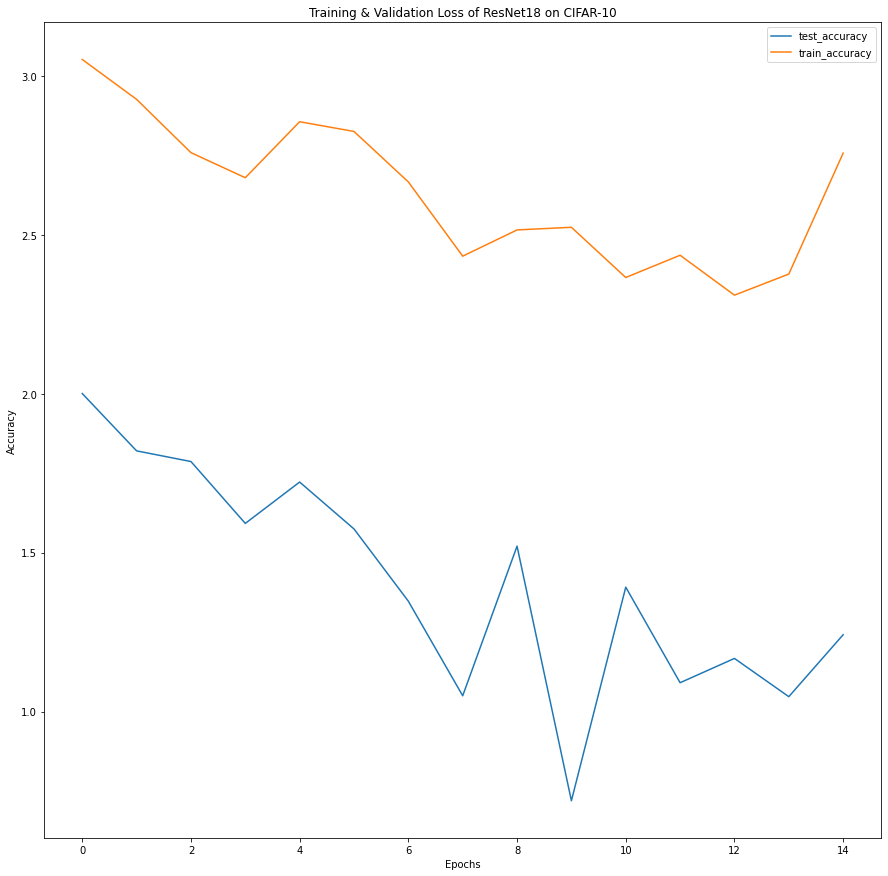

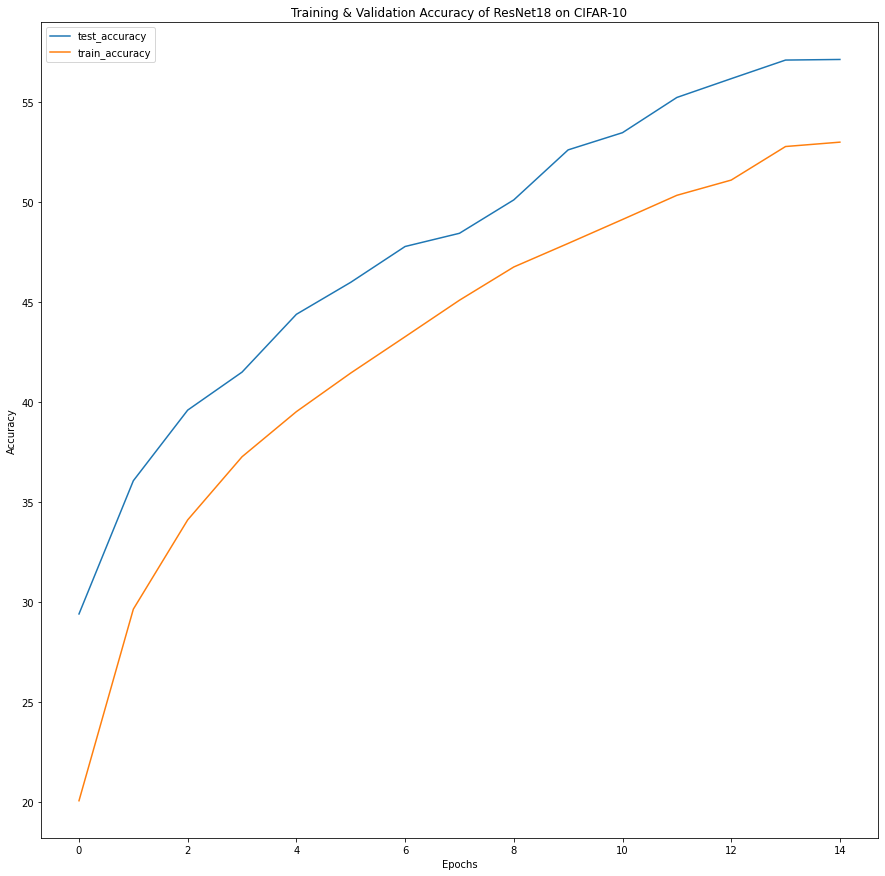

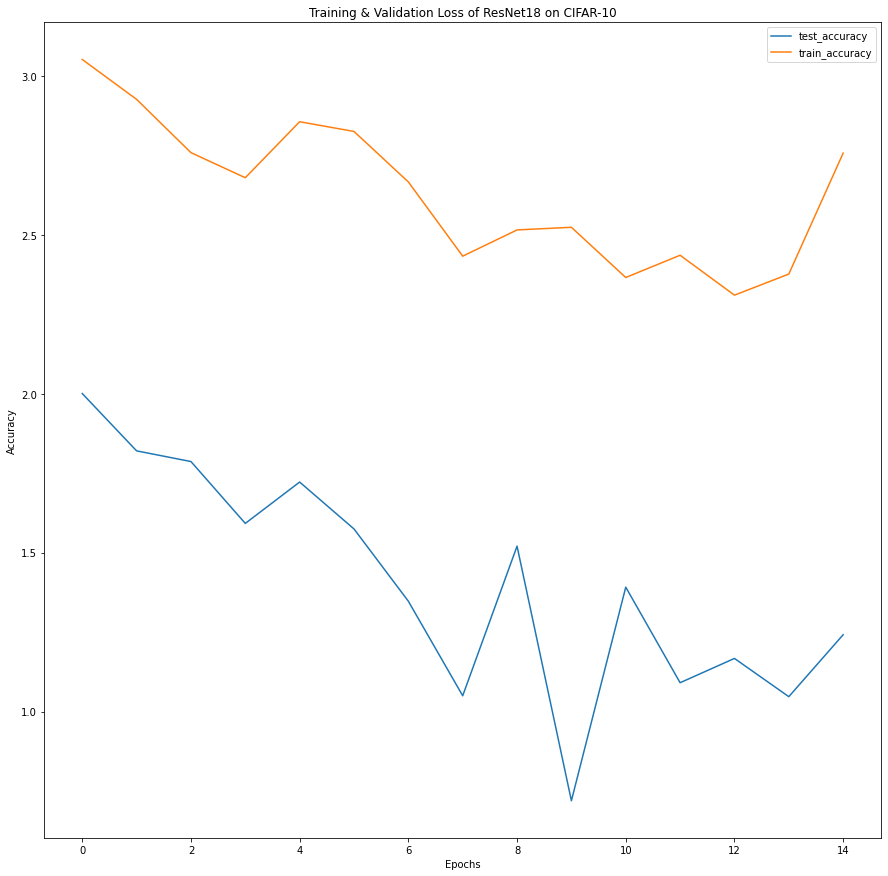

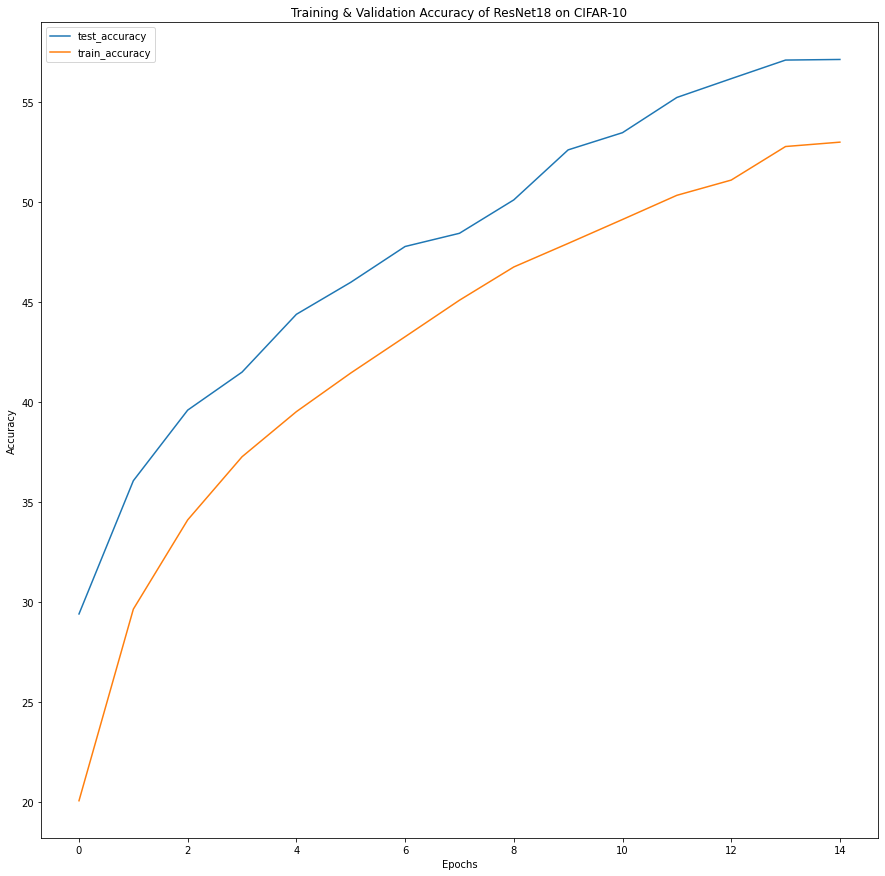

In [0]:
accuracyElements = [(model1.test_acc,"test_accuracy"),(model1.train_epoch_end,"train_accuracy")]
lossElements = [(model1.test_losses,"test_accuracy"),(model1.train_losses,"train_accuracy")]
for i in range(2):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10')

**Data for GradCam**

**GradCam Implementation**

In [0]:

images = [x['image'] for x in incorrectSamples[10:20]]
target_classes = [l['label'] for l in incorrectSamples[10:20]]
predicted_classes = [p['prediction'] for p in incorrectSamples[10:20]]
# print(images)
print('***target-classes***')
tc = [classes[t] for t in target_classes]


print('***predicted-classes***')
pc = [classes[p] for p in predicted_classes]


***target-classes***
***predicted-classes***


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


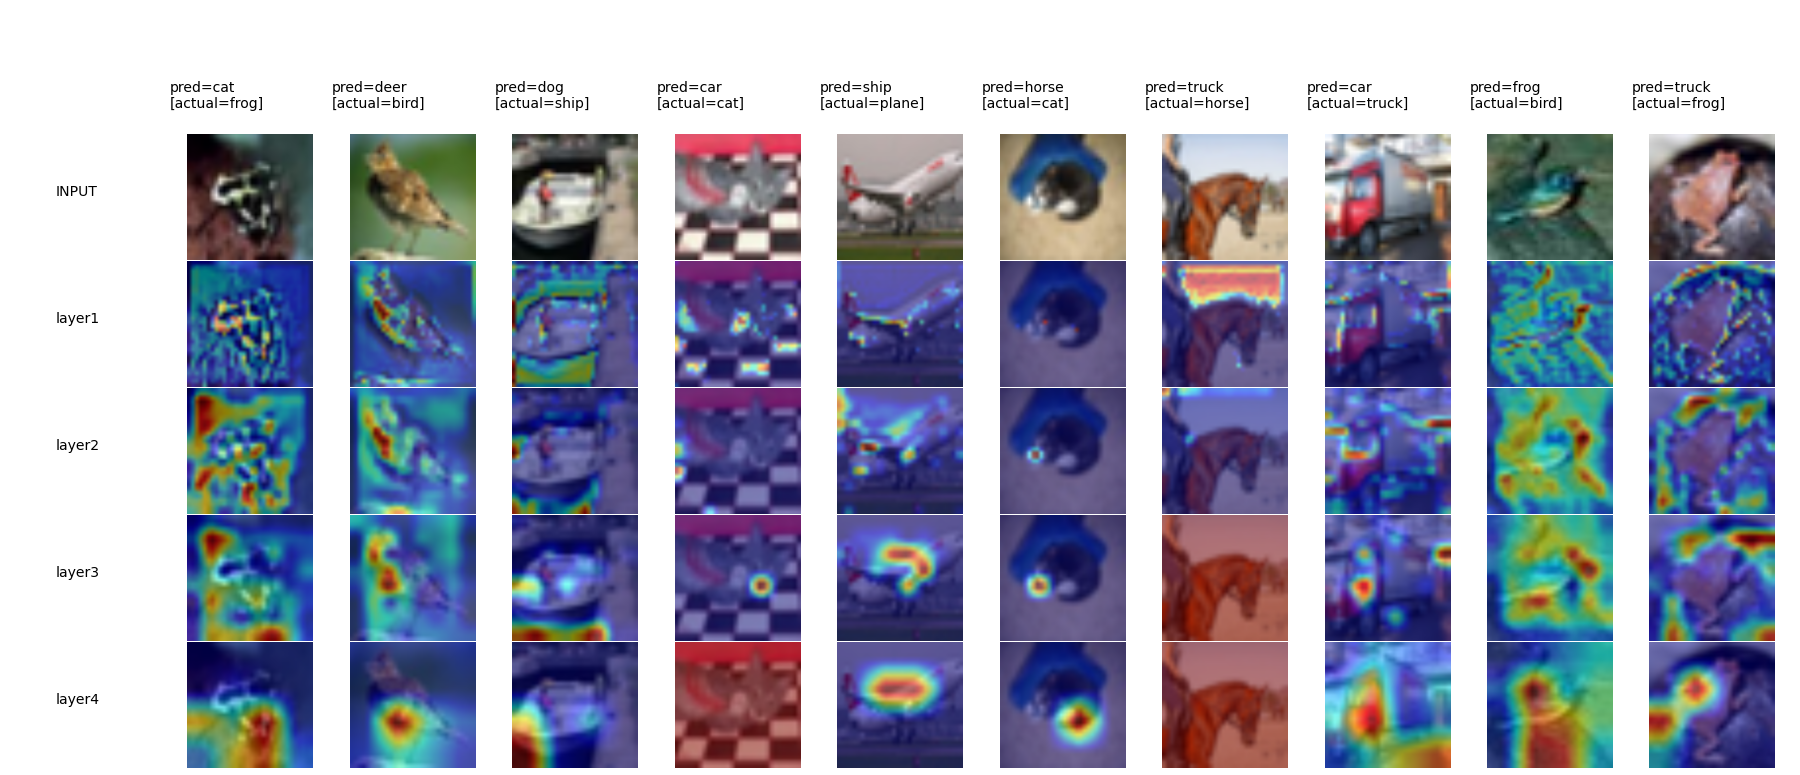

In [0]:

model = ResNet18().to(device)
image_size = (3,32,32)

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = gc.GRADCAM(images, device, target_classes, model, target_layers) # target_classes required only in GRADCAM func

gc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, tc, pc)


<Figure size 936x936 with 0 Axes>

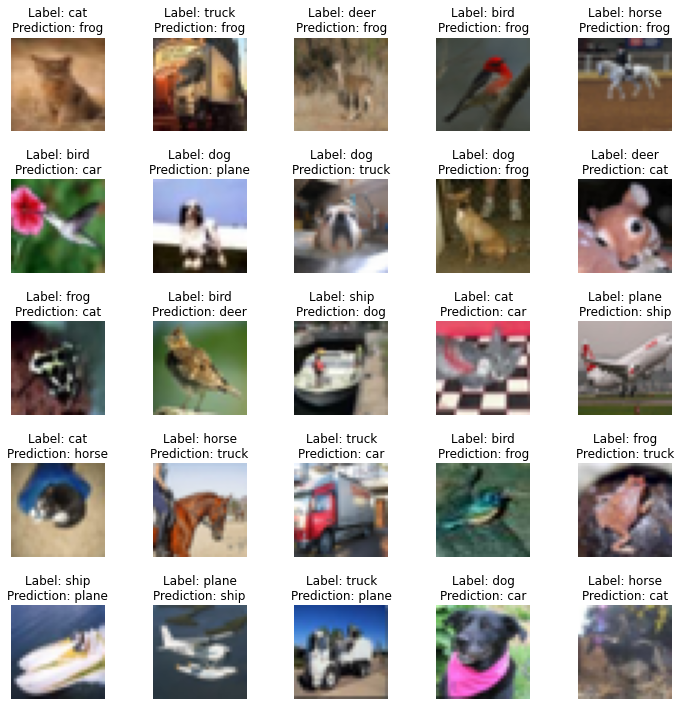

In [0]:
display.misclassifiedOnes(model, testLoader, incorrectSamples,'Misclassfied.png')